# Parallel Computing with Earthdata in the Cloud
## Replicating a Function Over Many Files with `coiled.function()`, Example Use for an SST-SSH Spatial Correlation Analysis

#### *Authors: Dean Henze and Jinbo Wang, NASA JPL PO.DAAC*

*Reference herein to any specific commercial product, process, or service by trade name, trademark, manufacturer, or otherwise, does not constitute or imply its endorsement by the United States Government or the Jet Propulsion Laboratory, California Institute of Technology.*

## Summary


Previous notebooks have covered the use of Dask and parallel computing applied to the type of task in the schematic below, where we wish to replicate a function over a set of files.

<img src="./schematic1.png" alt="sch1" width="500"/>

A separate notebook explores this workflow for computing spatial correlation maps between sea surface temperature (SST) and sea surface height (SSH) (an overview of the analysis is described below), where the parallel computations were performed with Dask on a local cluster using `dask.delayed()`. In this notebook, we perform the same computations, but parallelize them using the third party software/package `Coiled`. In short `Coiled` will allow us to spin up AWS virtual machines (EC2 instances) and create a distributed cluster out of them, all with a few lines of Python from within this notebook. For this type of parallel computation, we use `coiled.function()`'s, taking the place of `dask.delayed()`. *You will need a Coiled account, but once set up, you can run this notebook entirely from your laptop while the computations will be run on the distributed cluster in AWS.* 


#### SST-SSH Correlation Analysis

The analysis will generate global maps of spatial correlation between sea surface temperature (SST) and sea surface height (SSH). The analysis uses PO.DAAC hosted, gridded SSH and SST data sets:
* MEaSUREs gridded SSH Version 2205: 0.17° x 0.17° resolution, global map, one file per 5-days, https://doi.org/10.5067/SLREF-CDRV3
* GHRSST Level 4 MW_OI Global Foundation SST, V5.0: 0.25° x 0.25° resolution, global map, daily files, https://doi.org/10.5067/GHMWO-4FR05

The time period of overlap between these data sets is 1998 – 2020, with 1808 days in total overlapping. For each pair of SST, SSH files on these days, compute a map of spatial correlation between them, where the following method is used at each gridpoint:

<img src="./schematic_sst-ssh_corr.png" alt="sch_sst-ssh-corr" width="1000"/>

This notebook will first define the functions to read in the data and perform the computations, then test them on a single file. Next a smaller parallel computation will be performed on all pairs of files in 2018 (73 pairs in total), reducing what would have otherwise taken hours to minutes instead. Finally, an optional section will demonstrate what was used to perform the full computation on all 1808 pairs of files at 0.25 degree resolution.


## Requirements, prerequisite knowledge, learning outcomes

#### Requirements to run this notebook
* **Earthdata login account:** An Earthdata Login account is required to access data from the NASA Earthdata system. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. 
* **Coiled account:** Create a coiled account (free to sign up), and connect it to an AWS account. For more information on Coiled, setting up an account, and connecting it to an AWS account, see their website https://www.coiled.io. 
* **Compute environment:** This notebook can be run either in the cloud (AWS instance running in us-west-2), or on a local compute environment (e.g. laptop, server). Because we are using Coiled to spin up, access, and coordinate compute resources in AWS, this notebook will run equally as well both locally and in the cloud.


#### Prerequisite knowledge
* Please make sure you are comfortable with the [notebook on Dask basics](https://podaac.github.io/tutorials/notebooks/Advanced_cloud/basic_dask.html) and all prerequisites therein.

#### Learning outcomes
This notebook demonstrates how to use `dask.delayed()` with a local cluster on an analysis mirroring what someone might want to do in a real-world setting. As such, you will get better insight on how to apply this workflow to your own analysis. Further, this notebook touches briefly on choosing VM types, which may be many user's first introduction to the topic. 

In [1]:
# Built in packages
import time
import sys
import os

# Math / science packages
import xarray as xr
import numpy as np
from scipy.optimize import leastsq

# Plotting packages
from matplotlib import pylab as plt

# Cloud / parallel computing packages
import earthaccess
import coiled

## 1. Define functions

The main function implemented is `spatial_corrmap()`, which will return the map of correlations as a 2D array. The other functions below are called by `spatial_corrmap()`.  

In [2]:
def load_sst_ssh(gran_ssh, gran_sst):
    """
    Return SLA and SST variables for a single file each of the 
    SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205 and MW_OI-REMSS-L4-GLOB-v5.0 
    collections, respectively, returned as xarray.DataArray's. Input args are granule info 
    (earthaccess.results.DataGranule object's) for each collection.  
    """
    earthaccess.login(strategy="environment") # Confirm credentials are current
    
    # Get SLA and SST variables, loaded fully into local memory:
    ssh = xr.load_dataset(earthaccess.open([gran_ssh], provider='POCLOUD')[0])['SLA'][0,...]
    sst = xr.load_dataset(earthaccess.open([gran_sst], provider='POCLOUD')[0])['analysed_sst'][0,...]

    return ssh, sst

In [3]:
def spatialcorr(x, y, p1, p2):
    """
    Correlation between two 2D variables p1(x, y), p2(x, y), over the domain (x, y). Correlation is 
    computed between the anomalies of p1, p2, where anomalies for each variables are the deviations from 
    respective linear 2D surface fits.
    """
    # Compute anomalies:
    ssha, _ = anomalies_2Dsurf(x, y, p1) # See function further down.
    ssta, _ = anomalies_2Dsurf(x, y, p2)
    
    # Compute correlation coefficient:
    a, b = ssta.flatten(), ssha.flatten()
    if ( np.nansum(abs(a))==0 ) or ( np.nansum(abs(b))==0 ): # There are some cases where all anomalies for one var are 0.
        # In this case, correlation should be 0. Numpy will compute this correctly, but will also throw a lot of warnings.
        # Get around this by manually appending 0 instead.
        return 0
    else:
        return np.nanmean(a*b)/np.sqrt(np.nanvar(a) * np.nanvar(b))


def anomalies_2Dsurf(x, y, p):
    """
    Get anomalies for a variable over a 2D map. Done by fitting a bi-linear 2D surface 
    to the data (scipy) and taking the anomaly as the difference between each data point 
    and the surface. Surface can either be a linear or quadratic function.
    
    Inputs
    ------
    x, y: 1D array-like.
        Independent vars (likely the lon, lat coordinates).
    p: 2D array-like, of shape (len(y), len(x)).
        Dependent variable. 2D surface fit will be to p(x, y).
    
    Returns
    ------
    va, vm: 2D NumPy arrays
        Anomalies (va) and mean surface fit (vm).
    """
    # Functions to (1) output a 2D surface and (2) output the difference between 2D data and the computed surface:
    def surface(c,x0,y0): # Takes independent vars and poly coefficients
        a,b,c=c
        return a + b*x0 + c*y0
    
    def err(c,x0,y0,p): # Takes independent/dependent vars and poly coefficients
        a,b,c=c
        return p - (a + b*x0 + c*y0 )


    # Prep arrays and remove NAN's:
    xx, yy = np.meshgrid(x, y)
    xf=xx.flatten()
    yf=yy.flatten()
    pf=p.flatten()

    msk=~np.isnan(pf)
    pf=pf[msk]
    xf=xf[msk]
    yf=yf[msk]

    
    # Initial values of polynomial coefficients to start fitting algorithm off with:
    dpdx=(pf.max()-pf.min())/(xf.max()-xf.min())
    dpdy=(pf.max()-pf.min())/(yf.max()-yf.min())
    c = [pf.mean(),dpdx,dpdy]

    
    # Fit and compute anomalies:
    coef = leastsq(err,c,args=(xf,yf,pf))[0]
    vm = surface(coef, xx, yy) # mean surface
    va = p - vm # anomalies
    return va, vm

In [4]:
def spatial_corrmap(grans, lat_halfwin, lon_halfwin, lats=None, lons=None, f_notnull=0.5):
    """
    Get a 2D map of SSH-SST spatial correlation coefficients, for one each of the 
    SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205 and MW_OI-REMSS-L4-GLOB-v5.0 collections. 
    At each gridpoint, the spatial correlation is computed over a lat, lon window of size 
    2*lat_halfwin x 2*lon_halfwin. Correlation is computed from the SSH, SST anomalies, which are computed 
    in turn as the deviations from a fitted 2D surface over the window.
    
    Inputs
    ------
    grans: 2-tuple of earthaccess.results.DataGranule objects
        Granule info for the SSH, SST files (in that order). These objects contain https and S3 locations.
    lat_halfwin, lon_halfwin: floats
        Half window size in degrees for latitude and longitude dimensions, respectively.
    lats, lons: None or 1D array-like
        Latitude, longitude gridpoints at which to compute the correlations. 
        If None, will use the SSH grid.
    f_notnull: float between 0-1 (default = 0.5)
        Threshold fraction of non-NAN values in a window in order for the correlation to be computed,
        otherwise NAN is returned for that grid point. For edge cases, 'ghost' elements are counted as NAN.

    Returns
    ------
    coef: 2D numpy array
        Spatial correlation coefficients.
    
    lats, lons: 1D numpy arrays.
        Latitudes and longitudes creating the 2D grid that 'coef' was calculated on.
    """    
    # Load datafiles, convert SST longitude to (0,360), and interpolate SST to SSH grid:    
    ssh, sst = load_sst_ssh(*grans)
    sst = sst.roll(lon=len(sst['lon'])//2)
    sst['lon'] = sst['lon']+180
    sst = sst.interp(lon=ssh['Longitude'], lat=ssh['Latitude'])

    
    # Compute windows size and threshold number of non-nan points:
    dlat = (ssh['Latitude'][1]-ssh['Latitude'][0]).item()
    dlon = (ssh['Longitude'][1]-ssh['Longitude'][0]).item()
    nx_win = 2*round(lon_halfwin/dlon)
    ny_win = 2*round(lat_halfwin/dlat)
    n_thresh = nx_win*ny_win*f_notnull


    # Some prep work for efficient identification of windows where number of non-nan's < threshold:
        # Map of booleans for sst*ssh==np.nan
    notnul = (sst*ssh).notnull() 
        # Combine map and sst, ssh data into single Dataset for more efficient indexing:
    notnul = notnul.rename("notnul") # Needs a name to merge
    mergeddata = xr.merge([ssh, sst, notnul], compat="equals")
     

    # Compute spatial correlations over whole map:
    coef = []
    
    if lats is None:
        lats = ssh['Latitude'].data
        lons = ssh['Longitude'].data
    
    for lat_cen in lats:
        for lon_cen in lons:

            # Create window for both sst and ssh with xr.sel:
            lat_bottom = lat_cen - lat_halfwin
            lat_top = lat_cen + lat_halfwin
            lon_left = lon_cen - lon_halfwin
            lon_right = lon_cen + lon_halfwin
            data_win = mergeddata.sel(Longitude=slice(lon_left, lon_right), Latitude=slice(lat_bottom, lat_top))
    
            # If number of non-nan values in window is less than threshold 
            # value, append np.nan, else compute correlation coefficient:
            n_notnul = data_win["notnul"].sum().item()
            if n_notnul < n_thresh:
                coef.append(np.nan)
            else:
                c = spatialcorr(data_win['Longitude'], data_win['Latitude'], data_win['SLA'].data, data_win['analysed_sst'].data)
                coef.append(c)
    
    return np.array(coef).reshape((len(lats), len(lons))), np.array(lats), np.array(lons)

## 2. Get all matching pairs of SSH, SST files for 2018

The `spatial_corrmap()` function takes as one of its arguments a 2-tuple of `earthaccess.store.EarthAccessFile` objects, one each for SSH and SST (recall that `earthaccess.store.EarthAccessFile` objects are returned from a call to `earthaccess.open()`, and are passed to `Xarray`). This section will retrieve pairs of these objects for all SSH, SST data in 2018 on days where the data sets overlap. 

In [5]:
earthaccess.login()

In [6]:
## Granule info for all files in 2018:
dt2018 = ("2018-01-01", "2018-12-31")
grans_ssh = earthaccess.search_data(short_name="SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205", temporal=dt2018)
grans_sst = earthaccess.search_data(short_name="MW_OI-REMSS-L4-GLOB-v5.0", temporal=dt2018)

Granules found: 73
Granules found: 365


In [7]:
## File coverage dates extracted from filenames:
dates_ssh = [g['umm']['GranuleUR'].split('_')[-1][:8] for g in grans_ssh]
dates_sst = [g['umm']['GranuleUR'][:8] for g in grans_sst]
print(' SSH file days: ', dates_ssh[:8], '\n', 'SST file days: ', dates_sst[:8])

 SSH file days:  ['20180102', '20180107', '20180112', '20180117', '20180122', '20180127', '20180201', '20180206'] 
 SST file days:  ['20180101', '20180102', '20180103', '20180104', '20180105', '20180106', '20180107', '20180108']


In [8]:
## Separate granule info for dates where there are both SSH and SST files:
grans_ssh_analyze = []
grans_sst_analyze = []
for j in range(len(dates_ssh)):
    if dates_ssh[j] in dates_sst:
        grans_ssh_analyze.append(grans_ssh[j])
        grans_sst_analyze.append(grans_sst[dates_sst.index(dates_ssh[j])])

**The result is two lists of `earthaccess.results.DataGranule` objects, where the ith element of the SSH, SST lists contain granule info for the respective data sets on the same day:**

In [9]:
print(grans_ssh_analyze[0]['umm']['CollectionReference']['ShortName'], ':', len(grans_ssh_analyze), 'granules')
print([g['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime'] for g in grans_ssh_analyze[:4]])
print(grans_sst_analyze[0]['umm']['CollectionReference']['ShortName'], ':', len(grans_sst_analyze), 'granules')
print([g['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime'] for g in grans_sst_analyze[:4]])

SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205 : 73 granules
['2018-01-02T00:00:00.000Z', '2018-01-07T00:00:00.000Z', '2018-01-12T00:00:00.000Z', '2018-01-17T00:00:00.000Z']
MW_OI-REMSS-L4-GLOB-v5.0 : 73 granules
['2018-01-02T00:00:00.000Z', '2018-01-07T00:00:00.000Z', '2018-01-12T00:00:00.000Z', '2018-01-17T00:00:00.000Z']


## 3. Test the computation on a pair of files, output on a coarse resolution grid

To verify the functions work, we test them on the first pair of files. To reduce computation time, we compute them for a 2 degree x 2 degree output grid for now.

In [10]:
# Compute spatial correlation map for 2 degree x 2 degree resolution and time it:
t1 = time.time()

lats = np.arange(-80, 80, 2)
lons = np.arange(0, 359, 2)
coef, lats, lons = spatial_corrmap((grans_ssh_analyze[0], grans_sst_analyze[0]), 3, 3, lats=lats, lons=lons, f_notnull=0.5)

t2 = time.time()
comptime = round(t2-t1, 2)
print("Total computation time = " + str(comptime) + " seconds.")

Opening 1 granules, approx size: 0.01 GB


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Opening 1 granules, approx size: 0.0 GB


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Total computation time = 23.52 seconds.


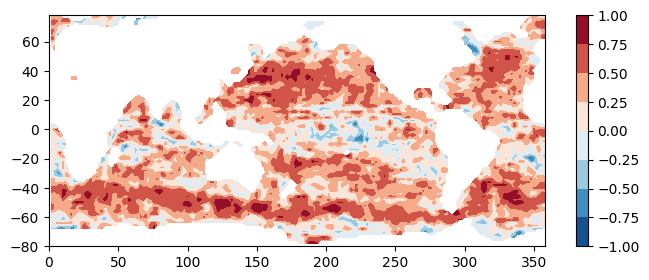

In [11]:
## Plot the results:
plt.figure(figsize=(8,3))
plt.contourf(lons, lats, coef, cmap='RdBu_r')
plt.colorbar()

### Estimation of computation time for higher resolution output and more files

The computation for one file computed on a 2 x 2 degree grid takes:

In [12]:
print(str(comptime) + " seconds.")

23.52 seconds.


then assuming linear scaling, processing one file at 0.5 x 0.5 degree resolution would take:

In [13]:
eta_fullres_seconds = comptime*(2/0.5)*(2/0.5)
eta_fullres_minutes = round(eta_fullres_seconds/60)
print(str(eta_fullres_minutes) + " minutes.")

6 minutes.


and for the record over all of 2018 would take:

In [14]:
eta_allfiles_hrs = round( (len(grans_ssh)*eta_fullres_minutes)/60, 1 )
eta_allfiles_days = round(eta_allfiles_hrs/24, 2)
print(str(len(grans_ssh)) + " granules for 2018.")
print(str(eta_allfiles_hrs) + " hours = " + str(eta_allfiles_days) + " days.")

73 granules for 2018.
7.3 hours = 0.3 days.


## 4. Parallel computations with Coiled Functions
The previous section showed that analyzing a year's worth of data at 0.5 x 0.5 degree output resolution would take hours. In this section, we use Coiled to parallelize this computation to take ~10 minutes and cost ~$1 (at the time this was written). Our task is to replicate and apply our function to all the files in 2018, which can be accomplished with a call to `coiled.function()`.

First, define a wrapper function which calls `spatial_corrmap()` for a pair of SSH, SST granules and collects the output into an `Xarray.DataArray`, returning it along with the date of granule coverages. We will parallelize this function rather than `spatial_corrmap()`, then take the output and save to netCDF files locally.

In [15]:
def corrmap_toda(grans, lat_halfwin=3, lon_halfwin=3, lats=None, lons=None, f_notnull=0.5):
    """
    Calls spatial_corrmap() for a pair of SSH, SST granules and collects output into an Xarray DataArray. 
    Returns this along with the date of the file coverages.
    """
    coef, lats, lons = spatial_corrmap(grans, lat_halfwin, lon_halfwin, lats=lats, lons=lons, f_notnull=0.5)
    date = grans[0]['umm']['GranuleUR'].split("_")[-1][:8] # get date from SSH UR.
    return date, xr.DataArray(data=coef, dims=["lat", "lon"], coords=dict(lon=lons, lat=lats), name='corr_ssh_sst')

Next, some prep work:

In [16]:
# All output will be saved to this local directory:
dir_results = "results/"
os.makedirs(dir_results, exist_ok=True)

# Latitudes, longitudes of output grid at 0.5 degree resolution:
lats = np.arange(-80, 80, 0.5)
lons = np.arange(0, 359, 0.5)

then setup the parallel computations and run!

In [17]:
## -----------------------------
## Perform and time computations
## -----------------------------

t1 = time.time()


# Wrap function in a Coiled function. Here is where we make cluster specifications like VM type:
corrmap_toda_parallel = coiled.function(
    region="us-west-2", spot_policy="on-demand", vm_type="m6i.large", 
    environ=earthaccess.auth_environ() # This ensures that our EDL credentials are passed to each worker.
    )(corrmap_toda)

# Optional: manually scale workers (Or omit this line to have Coiled adaptively scale):
corrmap_toda_parallel.cluster.scale(73)

# Begin computations:
grans_2tuples = list(zip(grans_ssh_analyze, grans_sst_analyze))
results = corrmap_toda_parallel.map(grans_2tuples, lat_halfwin=3, lon_halfwin=3, lats=lats, lons=lons, f_notnull=0.5)

# Retreive the results from the cluster as they become available and save as .nc files locally:
for date, result_da in results:
     result_da.to_netcdf(dir_results+"spatial-corr-map_ssh-sst_" + date + ".nc")

# Since we manually scaled up the cluster, we have to manually scale it back down if we want to stop using resources:
corrmap_toda_parallel.cluster.scale(1)


t2 = time.time()

Output()

╭────────────────────────────────────────── Package Info ──────────────────────────────────────────╮
│                                                     ╷                                            │
│   Package                                           │ Note                                       │
│ ╶───────────────────────────────────────────────────┼──────────────────────────────────────────╴ │
│   Babel                                             │ https://pypi.org/pypi                      │
│   Cartopy                                           │ https://pypi.org/pypi                      │
│   Deprecated                                        │ https://pypi.org/pypi                      │
│   Jinja2                                            │ https://pypi.org/pypi                      │
│   MarkupSafe                                        │ https://pypi.org/pypi                      │
│   Pillow                                            │ https://pypi.org/pypi                      │
│   PyNaCl                                            │ https://pypi.org/pypi                      │
│   PyYAML                                            │ https://pypi.org/pypi                      │
│   Pygments                                          │ https://pypi.org/pypi                      │
│   Send2Trash                                        │ https://pypi.org/pypi                      │
│   aiobotocore                                       │ https://pypi.org/pypi                      │
│   aiohttp                                           │ https://pypi.org/pypi                      │
│   aioitertools                                      │ https://pypi.org/pypi                      │
│   aiosignal                                         │ https://pypi.org/pypi                      │
│   anyio                                             │ https://pypi.org/pypi                      │
│   argon2-cffi                                       │ https://pypi.org/pypi                      │
│   argon2-cffi-bindings                              │ https://pypi.org/pypi                      │
│   arrow                                             │ https://pypi.org/pypi                      │
│   asttokens                                         │ https://pypi.org/pypi                      │
│   async-lru                                         │ https://pypi.org/pypi                      │
│   async-timeout                                     │ https://pypi.org/pypi                      │
│   attrs                                             │ https://pypi.org/pypi                      │
│   backcall                                          │ https://pypi.org/pypi                      │
│   backoff                                           │ https://pypi.org/pypi                      │
│   bcrypt                                            │ https://pypi.org/pypi                      │
│   beautifulsoup4                                    │ https://pypi.org/pypi                      │
│   bleach                                            │ https://pypi.org/pypi                      │
│   bokeh                                             │ https://pypi.org/pypi                      │
│   boto3                                             │ https://pypi.org/pypi                      │
│   botocore                                          │ https://pypi.org/pypi                      │
│   bounded-pool-executor                             │ https://pypi.org/pypi                      │
│   certifi                                           │ https://pypi.org/pypi                      │
│   cffi                                              │ https://pypi.org/pypi                      │
│   cftime                                            │ https://pypi.org/pypi                      │
│   charset-normalizer                                │ https://pypi.org/pypi                      │
│   click                                             │ https

Output()

2024-05-02 13:51:17,373 - distributed.deploy.adaptive - INFO - Adaptive scaling started: minimum=0 maximum=500
/Users/henze/miniconda3/envs/coiled2/lib/python3.11/site-packages/distributed/client.py:1391: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | Client | Scheduler | Workers |
+---------+--------+-----------+---------+
| toolz   | 0.12.0 | 0.12.1    | 0.12.1  |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [19]:
## What was the total computation time?
comptime = round(t2-t1, 2)
print("Total computation time = " + str(comptime) + " seconds = " + str(comptime/60) + " minutes.")

Total computation time = 544.3 seconds = 9.071666666666665 minutes.


In [20]:
corrmap_toda_parallel.cluster.shutdown()

2024-04-25 12:31:56,193 - distributed.deploy.adaptive_core - INFO - Adaptive stop
2024-04-25 12:31:56,671 - distributed.deploy.adaptive_core - INFO - Adaptive stop


### Test plots

**Colormaps of first three files**

In [ ]:
fns_results = [dir_results + f for f in os.listdir(dir_results) if f.endswith("nc")]
for fn in fns_results[:3]:
    testfile = xr.open_dataset(fn)
    testfile["corr_ssh_sst"].plot(figsize=(6,2), vmin=-1, vmax=1, cmap='RdBu_r')
    testfile.close()

**Colormap of mean correlation map for all files**

In [ ]:
test_allfiles = xr.open_mfdataset(fns_results, combine='nested', concat_dim='dummy_time')
test_allfiles["corr_ssh_sst"]

In [ ]:
test_allfiles["corr_ssh_sst"].mean(dim='dummy_time').plot(figsize=(8,3), vmin=-1, vmax=1, cmap='RdBu_r')
test_allfiles.close()

## Other notes

1. When using `coiled.function()`, we called `corrmap_toda_parallel.cluster.scale(73)` because we knew we wanted 73 workers to process the 73 files. However, this line isn't mandatory - if we left it out, `Coiled` would have started with 1 worker and then "adaptively scaled", figuring out that it needed 73 workers to do the job faster. It takes a few extra minutes for `Coiled` to figure out exactly how many workers to scale up to, so we short-cutted the process here since a few minutes in demo land is a lifetime.
2. When we made the call to `coiled.function()` we chose input args which would prioritize computation time over cost. Alternate choices could be made to prioritize cost instead, e.g. the following should be less expensive:
```
coiled.function(region="us-west-2", cpu=1, arm=True, spot_policy="spot_with_fallback", environ=earthaccess.auth_environ())(corrmap_toda)
```

## 5. Optional: Parallel computation on full record at 0.25 degree resolution

Only Section 1 needs to be run prior to this. Sections 2-4 can be skipped.

This section mirrors the workflow of Section 4, but processes all 1808 pairs of files, spanning a little over two decades, at higher resolution. To get an estimate of how long this would take without parallel computing, you can re-run section 3 but replace a value of 0.5 for the higher_res variable with 0.25 (in the part where we estimate comp times). Trying this on a few machines, we get that it would take anywhere from 21 to 34 hours to process the record over a single year, which means for 22 years it would take 19 to 31 days to complete the entire record.

First, we duplicate most of the code in Section 2, this time getting granule info objects for the entire record:

In [ ]:
earthaccess.login()

## Granule info for all files in both collections:
grans_ssh = earthaccess.search_data(short_name="SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205")
grans_sst = earthaccess.search_data(short_name="MW_OI-REMSS-L4-GLOB-v5.0")

## File coverage dates extracted from filenames:
dates_ssh = [g['umm']['GranuleUR'].split('_')[-1][:8] for g in grans_ssh]
dates_sst = [g['umm']['GranuleUR'][:8] for g in grans_sst]

## Separate granule info for dates where there are both SSH and SST files:
grans_ssh_analyze = []
grans_sst_analyze = []
for j in range(len(dates_ssh)):
    if dates_ssh[j] in dates_sst:
        grans_ssh_analyze.append(grans_ssh[j])
        grans_sst_analyze.append(grans_sst[dates_sst.index(dates_ssh[j])])

In [ ]:
def corrmap_toda(grans, lat_halfwin=3, lon_halfwin=3, lats=None, lons=None, f_notnull=0.5):
    """
    Calls spatial_corrmap() for a pair of SSH, SST granules and collects output into an Xarray DataArray. 
    Returns this along with the date of the file coverages.
    """
    coef, lats, lons = spatial_corrmap(grans, lat_halfwin, lon_halfwin, lats=lats, lons=lons, f_notnull=0.5)
    date = grans[0]['umm']['GranuleUR'].split("_")[-1][:8] # get date from SSH UR.
    return date, xr.DataArray(data=coef, dims=["lat", "lon"], coords=dict(lon=lons, lat=lats), name='corr_ssh_sst')

Some prep work:

In [ ]:
# Re-create the local directory to store results in:
dir_results = "results/"
if os.path.exists(dir_results) and os.path.isdir(dir_results):
    shutil.rmtree(dir_results)
os.makedirs(dir_results)

# Latitudes, longitudes of output grid at 0.5 degree resolution:
lats = np.arange(-80, 80.1, 0.25)
lons = np.arange(0, 360, 0.25)

then setup the parallel computations and run!

In [ ]:
## -----------------------------
## Perform and time computations
## -----------------------------

t1 = time.time()


# Wrap function in a Coiled function. Here is where we make cluster specifications like VM type:
corrmap_toda_parallel = coiled.function(
    region="us-west-2", spot_policy="on-demand", 
    vm_type = "t4g.small", # General purpose vm that strikes a balance between performance and cost.
    environ=earthaccess.auth_environ() # This ensures that our EDL credentials are passed to each worker.
    )(corrmap_toda)

# In our case, we limited the cluster to spinning up at most 250 VM's at once:
spatial_corrmap_tos3_coiled.cluster.adapt(minimum=1, maximum=250)

# Begin computations:
grans_2tuples = list(zip(grans_ssh_analyze, grans_sst_analyze))
results = corrmap_toda_parallel.map(grans_2tuples, lat_halfwin=3, lon_halfwin=3, lats=lats, lons=lons, f_notnull=0.5)

# Retreive the results from the cluster as they become available and save as .nc files locally:
for date, result_da in results:
     result_da.to_netcdf(dir_results+"spatial-corr-map_ssh-sst_" + date + ".nc")

# Since we manually scaled up the cluster, we have to manually scale it back down if we want to stop using resources:
corrmap_toda_parallel.cluster.scale(1)


t2 = time.time()

In [ ]:
## What was the total computation time?
comptime = round(t2-t1, 2)
print("Total computation time = " + str(comptime) + " seconds = " + str(comptime/60) + " minutes.")

In [20]:
corrmap_toda_parallel.cluster.shutdown()

2024-04-25 12:31:56,193 - distributed.deploy.adaptive_core - INFO - Adaptive stop
2024-04-25 12:31:56,671 - distributed.deploy.adaptive_core - INFO - Adaptive stop


### Test plots

**Colormaps of first three files**

In [ ]:
fns_results = [dir_results + f for f in os.listdir(dir_results) if f.endswith("nc")]
for fn in fns_results[:3]:
    testfile = xr.open_dataset(fn)
    testfile["corr_ssh_sst"].plot(figsize=(6,2), vmin=-1, vmax=1, cmap='RdBu_r')
    testfile.close()

**Colormap of mean correlation map for all files**

In [ ]:
test_allfiles = xr.open_mfdataset(fns_results, combine='nested', concat_dim='dummy_time')
test_allfiles["corr_ssh_sst"]

In [ ]:
test_allfiles["corr_ssh_sst"].mean(dim='dummy_time').plot(figsize=(8,3), vmin=-1, vmax=1, cmap='RdBu_r')
test_allfiles.close()